<a href="https://colab.research.google.com/github/GZabalaG/AIMaster/blob/main/Supervised/Actividad_Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [173]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import cv2 as cv

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Cargar una de las imágenes histológicas

<function matplotlib.pyplot.show>

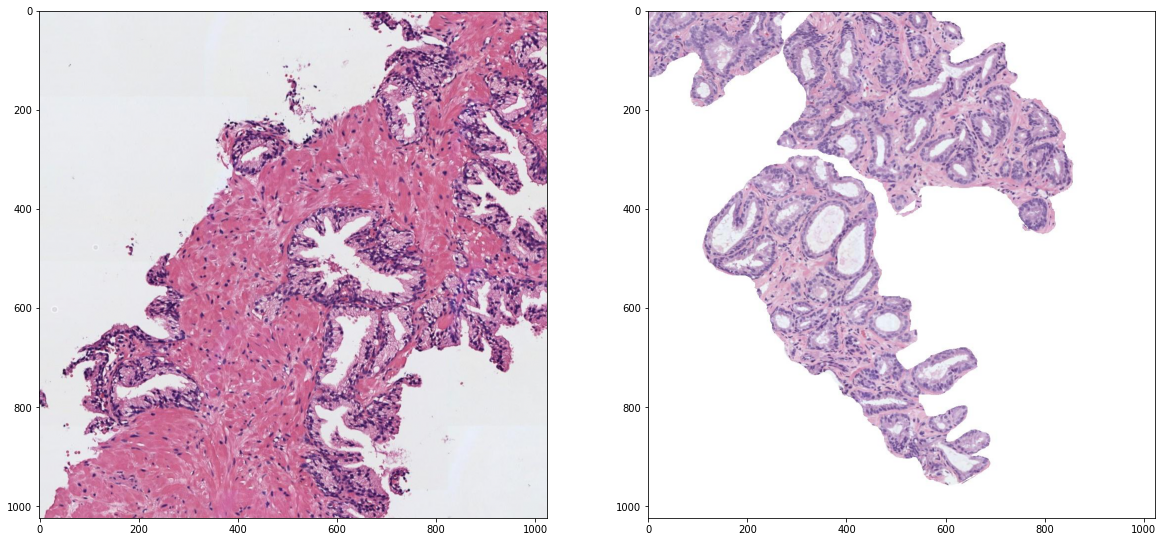

In [174]:
# Utiliza la librería skimage.io para leer la imagen 'histo_x.jpg' y visualízala usando la librería de matplotlib.
from skimage import io
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(20, 10))


histo_1_pre = io.imread('/content/drive/MyDrive/Master IA/Aprendizaje Supervisado/histo_1.jpeg')
histo_2_pre = io.imread('/content/drive/MyDrive/Master IA/Aprendizaje Supervisado/histo_2.jpeg')

# Recuerda normalizar la imagen diviéndola entre 255
histo_1 = histo_1_pre/255
histo_2 = histo_2_pre/255

ax[0].imshow(histo_1, cmap='gray')
ax[1].imshow(histo_2, cmap='gray')
plt.show

#### Realizar una transformación de color para convertir la imagen al espacio de color CMYK

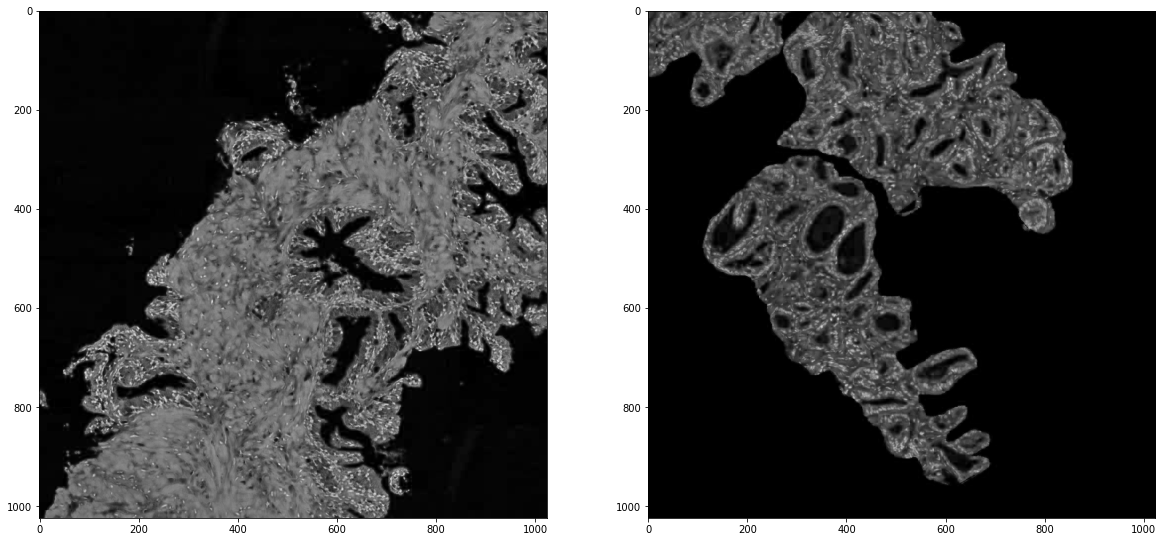

True

In [175]:
# 1) Extrae la componente magenta de la imagen (que corresponde a la región tisular)

with np.errstate(invalid='ignore', divide='ignore'):
   k1 = 1 - np.max(histo_1, axis=2)
   m1 = (1-histo_1[...,1] - k1)/(1-k1)

   k2 = 1 - np.max(histo_2, axis=2)
   m2 = (1-histo_2[...,1] - k2)/(1-k2)

# 2) Visualiza la imagen con la librería de matplotlib.
fig, ax = plt.subplots (1, 2, figsize=(20, 10))

ax[0].imshow(m1, cmap='gray')
ax[1].imshow(m2, cmap='gray')
plt.show()

# 3) Guarda la imagen Magenta con cv2.imwrite con el nombre "1_imagen_magenta.png"

cv.imwrite('1_imagen_magenta1.png', m1)
cv.imwrite('1_imagen_magenta2.png', m2)

#### Umbralizar la imagen para separar los píxeles del fondo de la región tisular

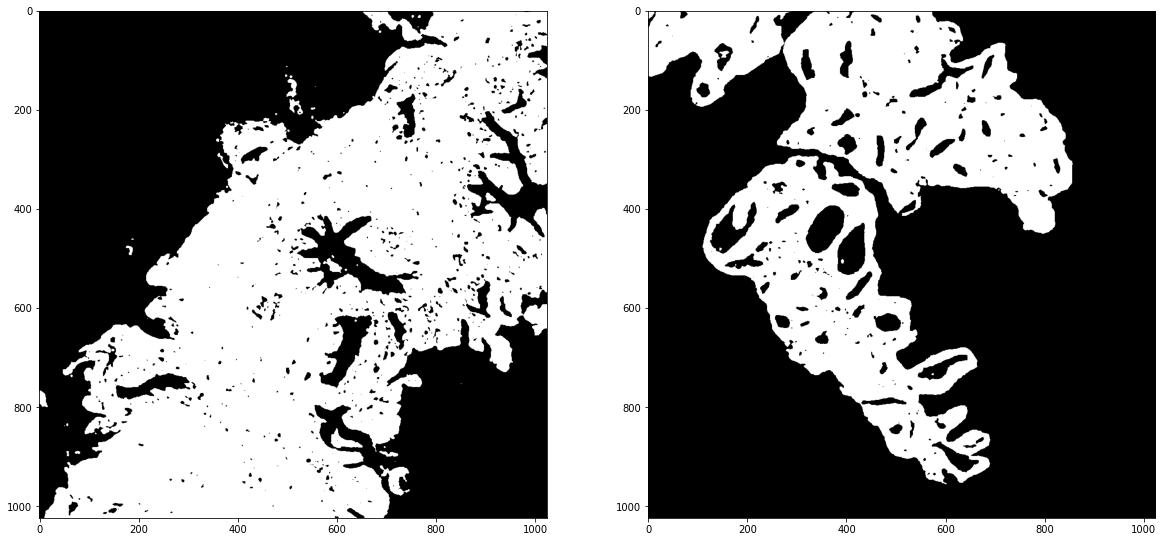

True

In [176]:
# 1) Convierte la imagen Magenta a formato "uint8"

m1u8 = (m1*255).astype('uint8')
m2u8 = (m2*255).astype('uint8')

# 2) Aplica un filtro gaussiano de tamaño 5x5

gauss1 = cv.GaussianBlur(m1u8,(5,5),0)
gauss2 = cv.GaussianBlur(m2u8,(5,5),0)

# 3) Umbraliza la imagen aplicando el método de Otsu
# 4) Aplica el umbral de manera que los píxeles del fondo y de los lúmenes sean 1s y el resto 0s. 

t, mask_1 = cv.threshold(gauss1, 0, 1, cv.THRESH_BINARY+cv.THRESH_OTSU)
t, mask_2 = cv.threshold(gauss2, 0, 1, cv.THRESH_BINARY+cv.THRESH_OTSU)

# 5) Visualiza la máscara resultante (imagen de 0s y 1s)

fig, ax = plt.subplots (1, 2, figsize=(20, 10))

ax[0].imshow(mask_1, cmap='gray')
ax[1].imshow(mask_2, cmap='gray')
plt.show()

# 6) Guarda la máscara multiplicándola por 255 con el nombre "2_mascara_con_artefactos.png"

mask_1 = mask_1 * 255
mask_2 = mask_2 * 255

cv.imwrite('2_mascara_con_artefactos1.png', mask_1)
cv.imwrite('2_mascara_con_artefactos2.png', mask_2)

#### Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

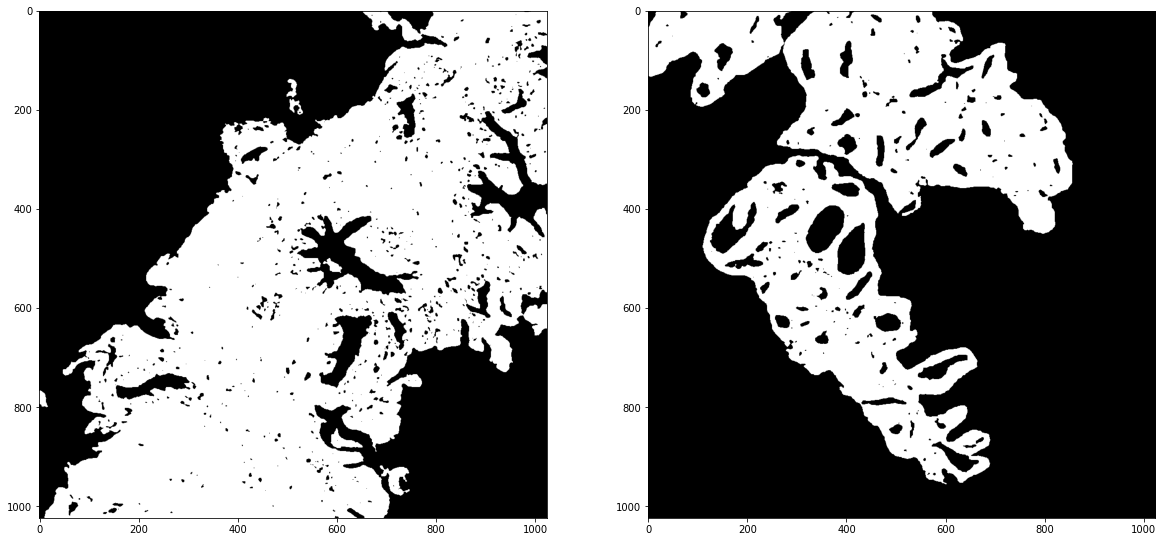

True

In [177]:
# 1) Utiliza la librería skimage.morphology.remove_small_objects. 
# Lee la documentación en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Fija el umbral en 300 píxeles y la conectividad del objeto en 8 píxeles.

from skimage import morphology

removed_1 = morphology.remove_small_objects((mask_1//255).astype(bool), 300, connectivity=8)
removed_2 = morphology.remove_small_objects((mask_2//255).astype(bool), 300, connectivity=8)

# 2) Convierte la máscara generada en formato uint8

removed_1 = (removed_1).astype('uint8')
removed_2 = (removed_2).astype('uint8')

# 3) Visualiza la máscara resultante

fig, ax = plt.subplots (1, 2, figsize=(20, 10))

ax[0].imshow(removed_1, cmap='gray')
ax[1].imshow(removed_2, cmap='gray')
plt.show()

# 4) Guarda la máscara multiplicándola por 255 con el nombre "3_mascara_sin_artefactos.png"
removed_1 = removed_1 * 255
removed_2 = removed_2 * 255

cv.imwrite('3_mascara_sin_artefactos1.png', removed_1)
cv.imwrite('3_mascara_sin_artefactos2.png', removed_2)

#### Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

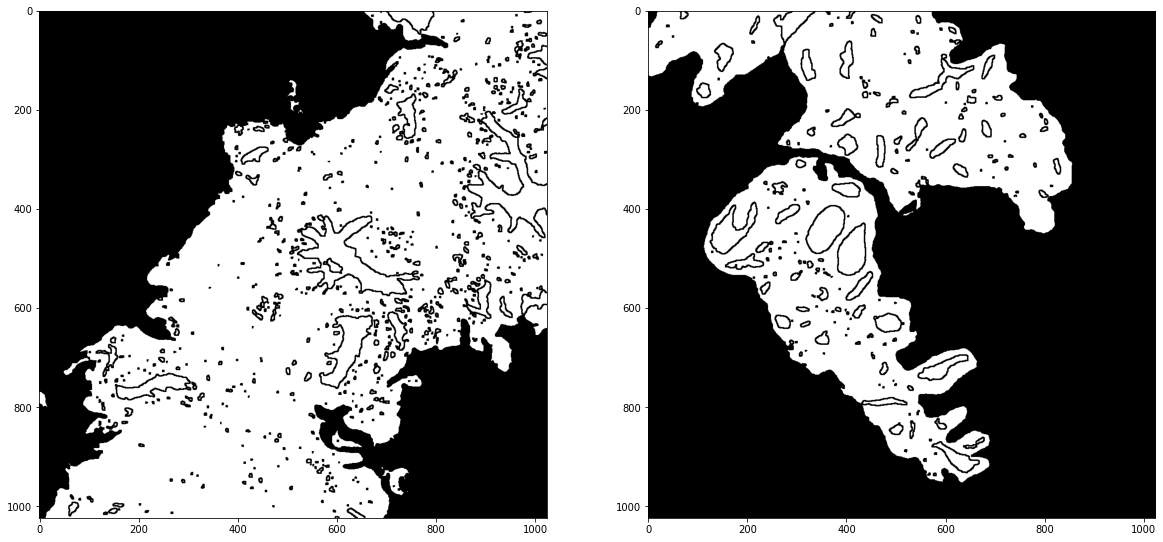

True

In [184]:
# 1) Aplica el algoritmo de expansión a partir de semillas para rellenar con 0s
# Pon dos semillas: una en la esquina superior izquierda y otra en la esquina inferior derecha.

canny1 = cv.Canny(removed_1, 255/3, 255)
canny2 = cv.Canny(removed_2, 255/3, 255)

kernel = np.ones((2,2), 'uint8')

canny1 = cv.dilate(canny1, kernel, iterations=2)
canny2 = cv.dilate(canny2, kernel, iterations=2)

h1, w1 = canny1.shape
h2, w2 = canny2.shape

ref1 = np.zeros((h1+2, w1+2), np.uint8)
ref2 = np.zeros((h2+2, w2+2), np.uint8)

cv.floodFill(canny1, ref1, (0,0), 255)
cv.floodFill(canny2, ref2, (0,0), 255)

cv.floodFill(canny1, ref1, (canny1.shape[0]-1,canny1.shape[1]-1), 255)
cv.floodFill(canny2, ref2, (canny2.shape[0]-1,canny2.shape[1]-1), 255)


mask_canny_1 = cv.bitwise_not(canny1)
mask_canny_2 = cv.bitwise_not(canny2)

# 2) Visualiza la máscara resultante

fig, ax = plt.subplots (1, 2, figsize=(20, 10))

ax[0].imshow(mask_canny_1, cmap='gray')
ax[1].imshow(mask_canny_2, cmap='gray')
plt.show()

# 3) Guarda la máscara multiplicándola por 255 con el nombre "4_mascara_lumenes.png"
mask_canny_1 = mask_canny_1 * 255
mask_canny_2 = mask_canny_2 * 255

cv.imwrite('4_mascara_lumenes1.png', mask_canny_1)
cv.imwrite('4_mascara_lumenes2.png', mask_canny_2)

#### Rellenar los objetos de los lúmenes

In [180]:
# 1) Rellena los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# 2) Convierte la máscara resultante en formato uint8
# 3) Visualiza la máscara
# 4) Guarda la máscara multiplicándola por 255 con el nombre "5_mascara_final.png"


#### Detectar y dibujar los contornos de los lúmenes sobre la imagen original

In [181]:
# 1) Encuentra los contornos de los lúmenes
# 2) Dibuja los contornos (de color verde) sobre la imagen original
# 3) Visualiza la imagen superpuesta
# 4) Guarda la imagen multiplicándola por 255 con el nombre "6_imagen_superpuesta.png"


#### Identificar y cropear el lumen más grande

In [182]:
# 1) Convierte la máscara de lúmenes en una imagen de etiquetas utilizando la librería skimage.measure
# 2) Calcula el área de cada uno de los lúmenes 
# 3) Obtén una máscara del lumen de mayor área
# 4) Haz un crop (recorte) del lumen de mayor área utilizando las coordenadas de la bounding box
# 5) Visualiza la máscara recortada del lumen
# 6) Guarda la imagen multiplicándola por 255 con el nombre "7_crop_image.png"


#### Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [183]:
# Calcula las siguientes características del crop del lumen anterior, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Longitud del eje mayor
# 8) Longitud del eje menor
# 9) Orientación
# 10) Perímetro
# 11) Solidez
# 12) Compacidad
# 13) Rectangularidad
